### Importing Libraries


In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [2]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
if IN_COLAB:
    !pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import requests
import json
import sys
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import numpy as np
import math

import time
from tqdm import tqdm

from google.cloud import bigquery
from google.oauth2 import service_account

from transformers import AutoModelForMaskedLM
from transformers import AutoModel, AutoConfig, AutoTokenizer, get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup, DataCollatorWithPadding

import torch
from torch.profiler import profile, record_function, ProfilerActivity
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import Dataset, DataLoader, IterableDataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings("ignore")   

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from sys import getsizeof
import gc

Device:  cuda


### Define configuration constants

In [5]:
class CFG:
    CPC_CODES_PATH = "../input/cpc-code-upto-subclass/CPC_codes_upto_subclass.csv"
    PATENTS_DATA_PATH = "../input/us-patents-abstracts-cpc/US_Patents_Titles_CPC_Section.csv"
    BERT_FOR_PATENTS_PATH = "../input/bert-for-patents/bert-for-patents-pytorch"
    DEBERTA_V3_LARGE_PATH = "../input/deberta-v3-large/deberta-v3-large"
    CPC_CODES_NUM_PATENTS_PATH = "../input/cpc-code-num-patents/cpc_code_num_patents.csv"
    MAX_TOKEN_LEN = 128
    DROPOUT_PROB = 0.2
    ATTENTION_INTERMEDIATE_SIZE = 512
    GOOGLE_CLOUD_CRED_JSON = '../input/googlecloudcred/us-patent-classification-d344a6ddc702.json'
    GOOGLE_CLOUD_PROJ_ID = 'us-patent-classification'
    BATCH_SIZE = 64
    NUM_EPOCHS = 5
    TRAIN_PATENT_START_YEAR = 2001
    TRAIN_PATENT_END_YEAR = 2018
    TEST_PATENT_START_YEAR = 2019
    TEST_PATENT_END_YEAR = 2022
    NUM_FOLDS = 6 #Total number of years used for training should be divisible by this number
    ENCODER_LR = 2e-5
    DECODER_LR = 2e-5
    MIN_LR = 1e-6
    EPS = 1e-8
    WEIGHT_DECAY = 0.01
    SCHEDULER = 'linear'
    NUM_WARMUP_STEPS = 0
    NUM_CYCLES = 0.5
    BETAS=(0.9, 0.999)
    MAX_GRAD_NORM = 1000
    PRINT_FREQ = 50
    INFINITY = 1e6
    F_TRAIN = 1
  
  # Parameters which will be added in subsequent code:
  # NUM_CLASSES, TRAIN_NUM_PATENTS

if IN_COLAB:
    CFG.CPC_CODES_PATH = "/content/drive/MyDrive/MachineLearning/ML_Deployment/Patent_Class_Inputs/cpc-code-upto-subclass/CPC_codes_upto_subclass.csv"
    CFG.PATENTS_DATA_PATH = "/content/drive/MyDrive/MachineLearning/ML_Deployment/Patent_Class_Inputs/us-patents-cpc-text/US_Patents_Titles_CPC_Section.csv"
    CFG.BERT_FOR_PATENTS_PATH = "/content/drive/MyDrive/MachineLearning/ML_Deployment/Patent_Class_Inputs/bert-for-patents-pytorch"
    CFG.GOOGLE_CLOUD_CRED_JSON = "/content/drive/MyDrive/MachineLearning/ML_Deployment/Patent_Class_Inputs/googlecloudcred/us-patent-classification-d344a6ddc702.json"

### List of CPC codes

In [6]:
cpc_codes_upto_subclass_df = pd.read_csv(CFG.CPC_CODES_PATH)
cpc_codes_upto_subclass_df.head()
num_codes = len(pd.unique(cpc_codes_upto_subclass_df['code']))
sections = pd.unique(cpc_codes_upto_subclass_df['section'])
df_len = len(cpc_codes_upto_subclass_df)

print("Number of rows in dataframe: ", df_len, "\n")
print("Number of CPC codes upto subclass: ", num_codes)
cpc_code_dict = dict(zip(cpc_codes_upto_subclass_df['code'].values, cpc_codes_upto_subclass_df.index))
cpc_code_section_dict = dict(zip(sections, range(len(sections))))

CFG.NUM_CLASSES = len(sections)

Number of rows in dataframe:  674 

Number of CPC codes upto subclass:  674


### Dowloaded Patent Data

In [7]:
patent_data_df = pd.read_csv(CFG.PATENTS_DATA_PATH)
patent_data_df.drop(columns = ['Unnamed: 0'], inplace = True)

(array([  2.,   0., 388., ...,   0.,   0.,   4.]),
 array([  2.        ,   2.42992126,   2.85984252, ..., 547.14015748,
        547.57007874, 548.        ]),
 <a list of 1270 Patch objects>)

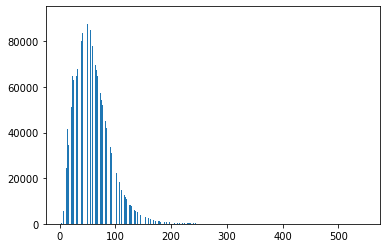

In [8]:
l_title = np.array(patent_data_df.title.apply(lambda x: len(x)))
plt.hist(l_title, bins='auto')

### Count the number of patents for each cpc_code

In [9]:
'''
cpc_code_count = dict(zip(cpc_codes_upto_subclass_df.index, [0 for x in range(0,len(cpc_codes_upto_subclass_df.index))]))

for cpc_code in cpc_code_dict.keys():
    
    cpc_code_count[cpc_code_dict[cpc_code]] = len(patent_data_df[patent_data_df['group_id'] == cpc_code].index)
    
plt.plot(cpc_code_count.keys(), cpc_code_count.values())

'''


"\ncpc_code_count = dict(zip(cpc_codes_upto_subclass_df.index, [0 for x in range(0,len(cpc_codes_upto_subclass_df.index))]))\n\nfor cpc_code in cpc_code_dict.keys():\n    \n    cpc_code_count[cpc_code_dict[cpc_code]] = len(patent_data_df[patent_data_df['group_id'] == cpc_code].index)\n    \nplt.plot(cpc_code_count.keys(), cpc_code_count.values())\n\n"

### Train Validation Split

In [10]:
# ================================================================================================
# train_test_split does not work if the "stratify" input has any label with only a single occurence
# So, we need to repeat those rows which have CPC codes with just a single occurence
# =================================================================================================
s = patent_data_df['section_id'].value_counts()
freq_1_s = s[s == 1]
for section in freq_1_s.index:
    s2 = patent_data_df[patent_data_df['section_id'] == section]
    patent_data_df = pd.concat([patent_data_df, s2], ignore_index = True)

In [11]:
train_val_df, test_df = train_test_split(patent_data_df, test_size=0.20, stratify = patent_data_df['section_id'])
train_df, valid_df = train_test_split(train_val_df, test_size=0.25, stratify = train_val_df['section_id'])

train_df.reset_index(inplace = True)
valid_df.reset_index(inplace = True)
test_df.reset_index(inplace = True)

train_df = train_df.groupby(['id', 'title'], sort = False, as_index = False).agg({'section_id':list})
valid_df = valid_df.groupby(['id', 'title'], sort = False, as_index = False).agg({'section_id':list})
test_df = test_df.groupby(['id', 'title'], sort = False, as_index = False).agg({'section_id':list})

del train_val_df

### Run a sample input through the BERT for Patents model

In [12]:
tokenizer = AutoTokenizer.from_pretrained(CFG.BERT_FOR_PATENTS_PATH)
CFG.tokenizer = tokenizer

In [13]:
'''
config = AutoConfig.from_pretrained(CFG.BERT_FOR_PATENTS_PATH)
config.max_position_embeddings = CFG.MAX_TOKEN_LEN
model_bert_for_patents = AutoModel.from_pretrained(CFG.BERT_FOR_PATENTS_PATH, config = config, ignore_mismatched_sizes=True)

sent = ["This is a patent", "Hello all"]
tokenized_sent = tokenizer(sent, truncation = True, add_special_tokens=True, max_length=CFG.MAX_TOKEN_LEN, padding="max_length",
                           return_offsets_mapping=False, return_tensors = "pt")
out = model_bert_for_patents(**tokenized_sent)

'''


'\nconfig = AutoConfig.from_pretrained(CFG.BERT_FOR_PATENTS_PATH)\nconfig.max_position_embeddings = CFG.MAX_TOKEN_LEN\nmodel_bert_for_patents = AutoModel.from_pretrained(CFG.BERT_FOR_PATENTS_PATH, config = config, ignore_mismatched_sizes=True)\n\nsent = ["This is a patent", "Hello all"]\ntokenized_sent = tokenizer(sent, truncation = True, add_special_tokens=True, max_length=CFG.MAX_TOKEN_LEN, padding="max_length",\n                           return_offsets_mapping=False, return_tensors = "pt")\nout = model_bert_for_patents(**tokenized_sent)\n\n'

### Build Custom Dataset

In [14]:
class PatentClassification_TrainDataset(Dataset):
    
    def __init__(self, cfg, cpc_code_section_dict, df):
        super(PatentClassification_TrainDataset).__init__()
        self.cfg = cfg
        self.cpc_code_section_dict = cpc_code_section_dict
        self.df = df
        
    def prepare_input(self, batch_num):
        
        start_idx = min(batch_num * self.cfg.BATCH_SIZE, len(self.df.index)-1)
        end_idx = min(start_idx + self.cfg.BATCH_SIZE - 1, len(self.df.index) - 1)
       
        inputs = self.cfg.tokenizer(list(self.df.loc[start_idx: end_idx, 'title']), truncation = True, add_special_tokens=True, 
                                    max_length=self.cfg.MAX_TOKEN_LEN, padding = 'longest')
        
        for k, v in inputs.items():
            inputs[k] = torch.tensor(v, dtype=torch.long)
            
        labels = torch.zeros(end_idx - start_idx + 1, self.cfg.NUM_CLASSES, dtype = torch.float)
        for i in range(labels.size(0)):
            indices = torch.tensor(list(map(self.cpc_code_section_dict.__getitem__, self.df.loc[i+start_idx, 'section_id'])))
            labels[i].index_fill_(dim = -1, index = indices, value = 1.0)         
            
        return inputs, labels
    
    def __len__(self):
        return len(self.df.index)
    
    def __getitem__(self, batch_num):
        
        inputs, labels = self.prepare_input(batch_num)
        
        return inputs, labels
    
'''
data_collator = DataCollatorWithPadding(tokenizer=CFG.tokenizer, padding = 'longest')    
def custom_collate_fn(batch):
    
    for idx, this_batch in enumerate(batch):
        inputs, labels = this_batch
        if idx != 0:
            inputs_dict_list.append(inputs)
            labels_list = torch.cat((labels_list, labels), dim=0)
        else:
            inputs_dict_list = [inputs]
            labels_list = labels
           
    padded_input_dict_list = data_collator(inputs_dict_list)
    
    return padded_input_dict_list, labels_list

'''

"\ndata_collator = DataCollatorWithPadding(tokenizer=CFG.tokenizer, padding = 'longest')    \ndef custom_collate_fn(batch):\n    \n    for idx, this_batch in enumerate(batch):\n        inputs, labels = this_batch\n        if idx != 0:\n            inputs_dict_list.append(inputs)\n            labels_list = torch.cat((labels_list, labels), dim=0)\n        else:\n            inputs_dict_list = [inputs]\n            labels_list = labels\n           \n    padded_input_dict_list = data_collator(inputs_dict_list)\n    \n    return padded_input_dict_list, labels_list\n\n"

### Build Custom Model

In [15]:
class PatentClassificationModel(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.model_config = AutoConfig.from_pretrained(self.cfg.BERT_FOR_PATENTS_PATH, output_hidden_states=False)
        self.model_config.max_position_embeddings = CFG.MAX_TOKEN_LEN
        self.model = AutoModel.from_pretrained(self.cfg.BERT_FOR_PATENTS_PATH, config = self.model_config, ignore_mismatched_sizes=True) 
        '''
        self.attention = torch.nn.Sequential(torch.nn.Linear(self.model_config.hidden_size, self.cfg.ATTENTION_INTERMEDIATE_SIZE),
                                             torch.nn.Tanh(),
                                             torch.nn.Linear(self.cfg.ATTENTION_INTERMEDIATE_SIZE, 1),
                                            torch.nn.Softmax(dim=1))
        self.fc_dropout = torch.nn.Dropout(self.cfg.DROPOUT_PROB)
        '''
        self.fc = torch.nn.Linear(self.model_config.hidden_size, self.cfg.NUM_CLASSES)
        self._init_weights(self.fc)
        
        
    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.model_config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, torch.nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.model_config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, torch.nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def forward(self, inputs):
        #one abstract can have multiple cpc codes, hence pass a list of cpc codes for each abstract
        model_outputs = self.model(**inputs)
        outputs = model_outputs.pooler_output
        outputs = self.fc(outputs)
        return outputs
        

In [16]:
train_dataset = PatentClassification_TrainDataset(CFG, cpc_code_section_dict, train_df)
train_dataloader = DataLoader(train_dataset, batch_size = None)

### Helper functions

In [17]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
    #param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in model.model.named_parameters() if (not any(nd in n for nd in no_decay)) and p.requires_grad],
         'lr': encoder_lr, 'weight_decay': weight_decay},
        {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay) and p.requires_grad],
         'lr': encoder_lr, 'weight_decay': 0.0},
        {'params': [p for n, p in model.named_parameters() if ("model" not in n) and p.requires_grad],
         'lr': decoder_lr, 'weight_decay': 0.0}
    ]
    return optimizer_parameters


    
# ====================================================
# scheduler
# ====================================================
def get_scheduler(cfg, optimizer, num_train_steps):
    if cfg.SCHEDULER == 'linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.NUM_WARMUP_STEPS, num_training_steps=num_train_steps
        )
    elif cfg.SCHEDULER == 'cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.NUM_WARMUP_STEPS, num_training_steps=num_train_steps, num_cycles=cfg.NUM_CYCLES
        )
    return scheduler


# ====================================================
# Function to calculate loss
# ====================================================
def get_loss(preds, labels, criterion):
    with torch.autocast(device_type = device.type):
        loss = criterion(preds.view(-1, 1), labels.view(-1, 1))  
        loss = loss.item()
    return loss
    

def train_fn(train_dataloader, num_batches, model, criterion, optimizer, epoch, scheduler, device):
    
    model.train()
    #scaler = torch.cuda.amp.GradScaler()
    loss_info = AverageMeter()
    start = end = time.time()
    
    for idx, batch in enumerate(train_dataloader):
                
        inputs, labels = batch
        
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        
        batch_size = labels.size(0)
        
        
        with torch.autocast(device_type = device.type):
            #model_run_start = time.time()
            outputs = model(inputs)
            #model_run_end = time.time()
            #print("Model run time: ", model_run_end - model_run_start, " s")
            loss = criterion(outputs.view(-1, 1), labels.view(-1, 1))
            
        loss_info.update(loss.item(), batch_size)
        
        
        # Calculate and scale gradients
        #scaler.scale(loss).backward()
        #backprop_run_start = time.time()
        loss.backward()
        #backprop_run_end = time.time()
        #print("Backprop step time: ", backprop_run_end - backprop_run_start, " s")
        
        #grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.MAX_GRAD_NORM)
        grad_norm = 0
        
        
        # Update Weights and Biases, Scaler
        #scaler.step(optimizer)
        #optimizer_run_start = time.time()
        optimizer.step()
        #optimizer_run_end = time.time()
        #print("Optimizer step time: ", optimizer_run_end - optimizer_run_start, " s")
        
        #scaler.update()
        
        #Update Scheduler
        scheduler.step()
        
        # Set all gradients to 0
        optimizer.zero_grad(set_to_none = True)
        
 
        
        if idx % CFG.PRINT_FREQ == 0 or idx == num_batches - 1:
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad (Invalid): {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, idx, num_batches, 
                          remain=timeSince(start, float(idx+1)/num_batches),
                          loss=loss_info,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        torch.cuda.empty_cache()
    
    return loss_info.avg

def valid_fn(valid_dataloader, num_batches, model, criterion, epoch, device):
    
    model.eval()
    loss_info = AverageMeter()
    start = end = time.time()
    
    for idx, batch in enumerate(valid_dataloader):
                
        inputs, labels = batch
        
        batch_size = labels.size(0)
        
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        
        
        with torch.autocast(device_type = device.type):
            with torch.no_grad():
                outputs = model(inputs)
            loss = criterion(outputs.view(-1, 1), labels.view(-1, 1))      
                    
        loss_info.update(loss.item(), batch_size)
        try:
            preds_concat = torch.cat((preds_concat, outputs), dim = 0)
            labels_concat = torch.cat((labels_concat, labels), dim = 0)
        except:    
            preds_concat = outputs
            labels_concat = labels
        
        if idx % CFG.PRINT_FREQ == 0 or idx == num_batches - 1:
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(epoch+1, idx, num_batches, 
                          remain=timeSince(start, float(idx+1)/num_batches),
                          loss=loss_info))
        
        
        overall_val_loss = get_loss(preds_concat, labels_concat, criterion)
        
        torch.cuda.empty_cache()
        
        return overall_val_loss

### Training loop

In [18]:
def train_loop():
        
    model = PatentClassificationModel(CFG)
    model.to(device)
    
    #optimizer_parameters = get_optimizer_params(model,encoder_lr=CFG.ENCODER_LR,decoder_lr=CFG.DECODER_LR,weight_decay=CFG.WEIGHT_DECAY)
    optimizer_parameters = [p for p in model.parameters() if p.requires_grad]
    
    optimizer = AdamW(optimizer_parameters, lr=CFG.ENCODER_LR, eps=CFG.EPS, betas=CFG.BETAS)
    
    num_train_batches = len(train_df)// CFG.BATCH_SIZE
    num_val_batches = len(valid_df)// CFG.BATCH_SIZE
    num_train_steps = num_train_batches * CFG.NUM_EPOCHS
    
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)
    
    # ====================================================
    # loop
    # ====================================================
    criterion = torch.nn.BCEWithLogitsLoss(reduction="mean")
    
    best_loss = CFG.INFINITY
    best_epoch = 0
    
    train_dataset = PatentClassification_TrainDataset(CFG, cpc_code_section_dict, train_df)
    valid_dataset = PatentClassification_TrainDataset(CFG, cpc_code_section_dict, valid_df)
    
    #num_workers = 2 gives best speed (for GPU)
    train_dataloader = DataLoader(train_dataset, batch_size = None, num_workers = 2) 
    valid_dataloader = DataLoader(valid_dataset, batch_size = None, num_workers = 2) 
    
    
    for epoch in range(CFG.NUM_EPOCHS):   
        
        start_time = time.time()
        
        #train
        avg_train_loss = train_fn(train_dataloader, num_train_batches, model, criterion, optimizer, epoch, scheduler, device)
        
        #eval
        overall_val_loss = valid_fn(valid_dataloader, num_val_batches, model, criterion, epoch, device)
        
        elapsed = time.time() - start_time
        
        print(f"Epoch {epoch+1} - avg_train_loss: {avg_train_loss:.4f}, overall_val_loss: {overall_val_loss: 4f} time: {elapsed:.0f}s")
        torch.save({'model': model.state_dict()}, f"BERT_For_Patents_FineTuned_{epoch+1}.pth")
            
        if overall_val_loss < best_loss:
            best_loss = overall_val_loss
            best_epoch = epoch + 1
            torch.save({'model': model.state_dict()}, "BERT_For_Patents_FineTuned.pth")
            
    print(f'Best Epoch {best_epoch} - Best Loss: {best_loss:.4f}')
            
    torch.cuda.empty_cache()
    gc.collect()
              

In [19]:
if __name__ == '__main__':
    
    if CFG.F_TRAIN:
        torch.cuda.empty_cache()
        gc.collect()
        train_loop()
        

Some weights of the model checkpoint at /content/drive/MyDrive/MachineLearning/ML_Deployment/Patent_Class_Inputs/bert-for-patents-pytorch were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initiali

Epoch: [1][0/43680] Elapsed 0m 2s (remain 1492m 33s) Loss: 0.6948(0.6948) Grad: 4.6618  LR: 0.00002000  
Epoch: [1][50/43680] Elapsed 0m 26s (remain 374m 41s) Loss: 0.4114(0.4265) Grad: 0.4051  LR: 0.00002000  
Epoch: [1][100/43680] Elapsed 0m 53s (remain 384m 34s) Loss: 0.4339(0.4178) Grad: 0.5891  LR: 0.00001999  
Epoch: [1][150/43680] Elapsed 1m 20s (remain 385m 45s) Loss: 0.4346(0.4141) Grad: 0.3535  LR: 0.00001999  
Epoch: [1][200/43680] Elapsed 1m 45s (remain 380m 58s) Loss: 0.4132(0.4120) Grad: 0.5673  LR: 0.00001998  


KeyboardInterrupt: ignored